[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/reactivation.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/reactivation.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Freactivation.ipynb)

# Reactivation 

Here, we will show how to use the [`AssemblyReact`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/ensemble/assembly_reactivation/#neuro_py.ensemble.assembly_reactivation.AssemblyReact)
class to identify assemblies and assess reactivation during post-task sleep

---

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

# from neuro_py
# plotting
import matplotlib.pyplot as plt

# core tools
import nelpy as nel
import numpy as np
import seaborn as sns

from neuro_py.ensemble.assembly_reactivation import AssemblyReact
from neuro_py.io import loading
from neuro_py.process.peri_event import event_triggered_average_fast
import neuro_py as npy

## Section 1: Pick basepath and initialize AssemblyReact class

Here we will use CA1 pyramidal cells.

In [2]:
basepath = r"S:\data\HMC\HMC1\day8"

assembly_react = AssemblyReact(
    basepath=basepath,
    brainRegion="CA1",
    putativeCellType="Pyr",
    z_mat_dt=0.01,
)

Also, load brain states for later use.

In [3]:
# load theta epochs
state_dict = loading.load_SleepState_states(basepath)
theta_epochs = nel.EpochArray(
    state_dict["THETA"],
)
nrem_epochs = nel.EpochArray(
    state_dict["NREMstate"],
)
theta_epochs, nrem_epochs

(<EpochArray at 0x1bf15b90c90: 125 epochs> of length 35:04 minutes,
 <EpochArray at 0x1bf15df0a50: 88 epochs> of length 2:16:25 hours)

## Section 2: Load spike data, session epochs, and ripple events

You can see there there are nice printouts that display important information about the class

In [4]:
# load need data (spikes, ripples, epochs)
assembly_react.load_data()
assembly_react

<AssemblyReact: 75 units> of length 6:36:57:689 hours

Locate the session from which you want to detect assemblies.

Here we can see a *novel* `linear` track is the second epoch.

In [5]:
assembly_react.epoch_df

,name,startTime,stopTime,environment,behavioralParadigm,notes,manipulation,stimuli,basepath
0,preSleep_210411_064951,0.0,9544.56315,sleep,NaN,NaN,NaN,NaN,S:\data\HMC\HMC1\day8
1,maze_210411_095201,9544.5632,11752.80635,linear,1,novel,NaN,NaN,S:\data\HMC\HMC1\day8
2,postSleep_210411_103522,11752.8064,23817.68955,sleep,NaN,NaN,NaN,NaN,S:\data\HMC\HMC1\day8


## Section 3: Detect assembles in linear track during theta

You can see we have detected 15 assemblies

In [6]:
assembly_react.get_weights(epoch=assembly_react.epochs[1] & theta_epochs)
assembly_react

<AssemblyReact: 75 units, 15 assemblies> of length 6:36:57:689 hours

## Section 4: Analyze the obtained assemblies

### Section 4.1: Visualize assembly weights

Each column is a assembly and each row is a cell

The color indicates if the cell was a significant contributor (members) to that assembly
* you can find these members with assembly_members = assembly_react.find_members()

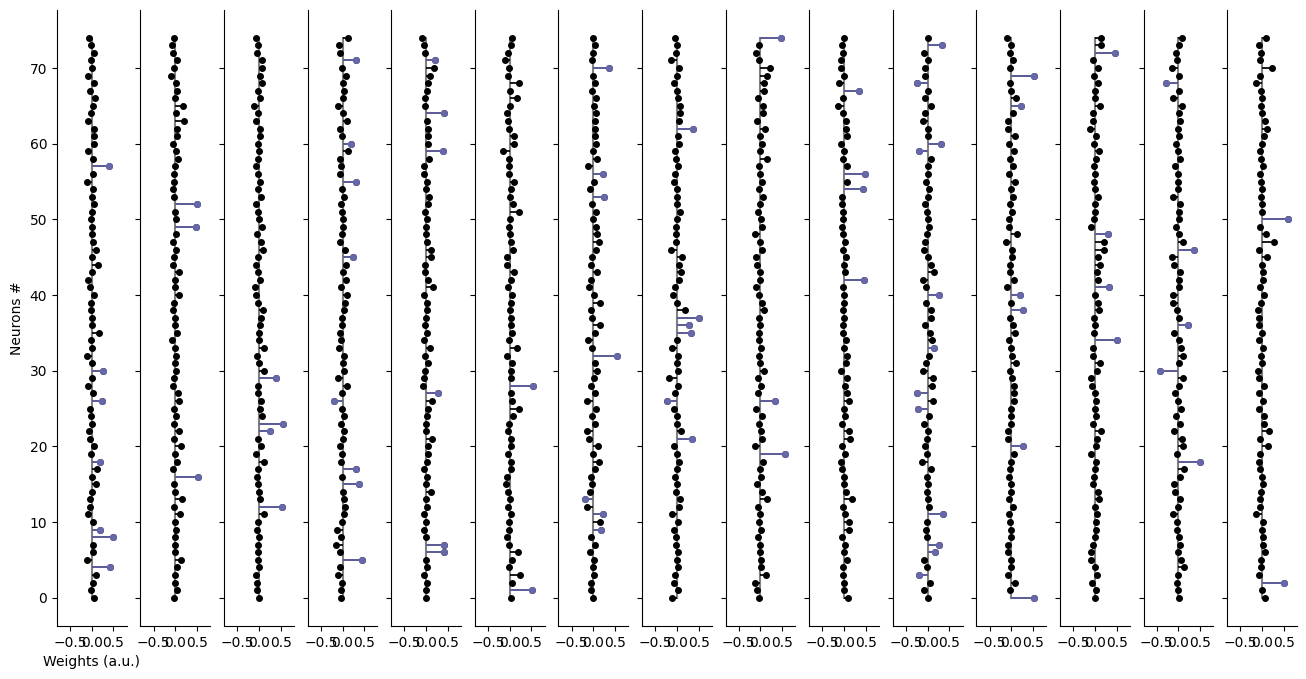

In [7]:
assembly_react.plot()
plt.show()

### Section 4.2: Compute time-resolved activations for each assembly

Will take around a minute to run.

In [8]:
assembly_act = assembly_react.get_assembly_act()
assembly_act

<AnalogSignalArray at 0x1bf1804c990: 15 signals> for a total of 6:36:57:680 hours

### Section 4.3: Get assembly strengths around ripples in pre-sleep, the task, and in post-sleep epochs

In [9]:
nrem_ripples = assembly_react.ripples & nrem_epochs

psth_swr_pre = event_triggered_average_fast(
    assembly_act.data,
    nrem_ripples[assembly_react.epochs[0]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)
psth_swr_task = event_triggered_average_fast(
    assembly_act.data,
    assembly_react.ripples[assembly_react.epochs[1]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)
psth_swr_post = event_triggered_average_fast(
    assembly_act.data,
    nrem_ripples[assembly_react.epochs[2]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)

# round time index to 3 decimals for plotting
psth_swr_pre.index = np.round(psth_swr_pre.index, 3)
psth_swr_task.index = np.round(psth_swr_task.index, 3)
psth_swr_post.index = np.round(psth_swr_post.index, 3)

### Section 4.4: Visualize reactivation dynamics during post-task ripples

Here, we have plotted *Pre*, *Post*, and *Post* subtracted by *Pre* to estimate the difference.

You can see that many of the assembles have a higher reactivation during the post-task ripples compared to the pre-task ripples.

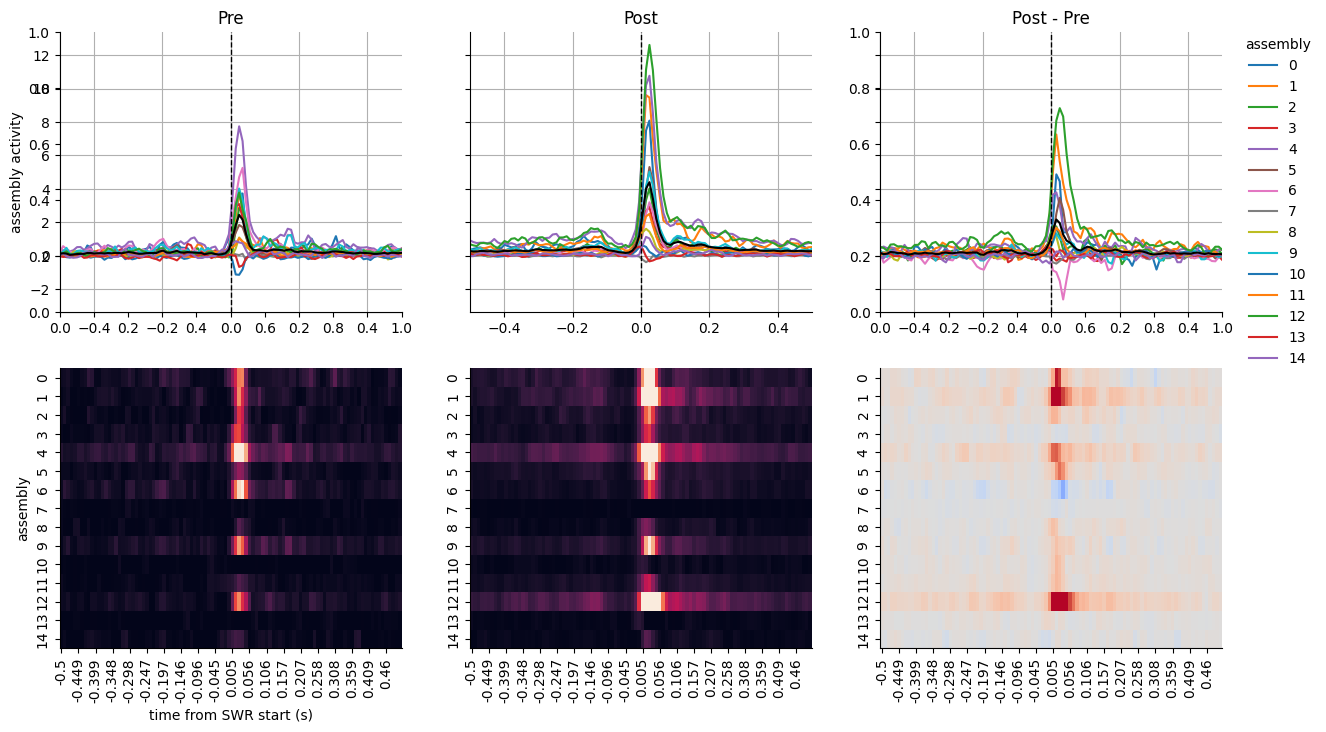

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
ax = ax.flatten()

# share y axis of first row
ax[0] = plt.subplot(231, sharey=ax[1])
ax[2] = plt.subplot(233, sharey=ax[0])

# plot assembly ripple psth
psth_swr_pre.plot(ax=ax[0], legend=False)
psth_swr_post.plot(ax=ax[1], legend=False)
(psth_swr_post - psth_swr_pre).plot(ax=ax[2])

# plot mean assembly ripple psth
psth_swr_pre.mean(axis=1).plot(ax=ax[0], color="k", legend=False)
psth_swr_post.mean(axis=1).plot(ax=ax[1], color="k", legend=False)
(psth_swr_post - psth_swr_pre).mean(axis=1).plot(ax=ax[2], color="k")

# plot assembly ripple psth heatmap
sns.heatmap(psth_swr_pre.T, ax=ax[3], cbar=False, vmin=0, vmax=5)
sns.heatmap(psth_swr_post.T, ax=ax[4], cbar=False, vmin=0, vmax=5)
sns.heatmap(
    (psth_swr_post - psth_swr_pre).T,
    ax=ax[5],
    cbar=False,
    vmin=-5,
    vmax=5,
    cmap="coolwarm",
)

for ax_ in ax[:3]:
    # dashed line at zero
    ax_.axvline(0, linestyle="--", color="k", linewidth=1)
    # set x axis limits
    ax_.set_xlim(-0.5, 0.5)
    # add grid lines
    ax_.grid()

ax[0].set_title("Pre")
ax[1].set_title("Post")
ax[2].set_title("Post - Pre")

# move legend
ax[2].legend(
    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=False, title="assembly"
)

# add labels
ax[0].set_ylabel("assembly activity")
ax[3].set_ylabel("assembly")
ax[3].set_xlabel("time from SWR start (s)")

# clean axis using seaborn
sns.despine()

plt.show()

---

## Section 5: Cross-Structural Assembly Detection

The `AssemblyReact` class now supports cross-structural assembly detection, which allows you to identify assemblies that span across different brain regions, cell types, or any other categorical grouping. This is particularly useful for studying cross-regional coordination.

### Section 5.1: Load data from multiple brain regions

For this demonstration, we'll detect assemblies that span across CA1 and PFC regions.

In [11]:
basepath = r"U:\data\hpc_ctx_project\HP18\hp18_day40_20250514"
# load theta epochs
state_dict = loading.load_SleepState_states(basepath)
theta_epochs = nel.EpochArray(
    state_dict["THETA"],
)
nrem_epochs = nel.EpochArray(
    state_dict["NREMstate"],
)
ripples = npy.io.load_ripples_events(basepath, return_epoch_array=True)

epoch_df = loading.load_epoch(basepath)
epoch_df = npy.session.compress_repeated_epochs(epoch_df)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime, epoch_df.stopTime]).T)
pre_task_post = npy.session.find_multitask_pre_post(
    epoch_df.environment, post_sleep_flank=True, pre_sleep_common=True
)

# Load spike data from both CA1 and PFC regions
st, cell_metrics = loading.load_spikes(
    basepath, brainRegion="CA1|PFC", putativeCellType="Pyr"
)
brain_regions = np.array(["unknown"] * st.n_active)
brain_regions[cell_metrics.brainRegion.str.contains("CA1")] = "CA1"
brain_regions[cell_metrics.brainRegion.str.contains("PFC")] = "PFC"

# sort by brain region for easier visualization
idx = np.argsort(brain_regions)

st._data = st.data[idx]
brain_regions = brain_regions[idx]
cell_metrics = cell_metrics.iloc[idx].reset_index(drop=True)

### Section 5.2: Standard vs Cross-Structural Assembly Detection

Let's compare standard assembly detection (which finds assemblies within and across regions) with cross-structural detection (which only finds assemblies spanning multiple regions).

In [12]:
# Standard assembly detection (finds both within-region and cross-region assemblies)
assembly_react_standard = AssemblyReact(weight_dt=0.05, z_mat_dt=0.005)
assembly_react_standard.add_st(st)
assembly_react_standard.epochs = beh_epochs
assembly_react_standard.get_weights(
    epoch=assembly_react_standard.epochs[pre_task_post[0][1].item()] & theta_epochs
)

print(f"Standard detection found {assembly_react_standard.n_assemblies()} assemblies")

# Cross-structural assembly detection (only finds assemblies spanning multiple regions)
assembly_react_cross = AssemblyReact(
    weight_dt=0.05,
    z_mat_dt=0.005,
    cross_structural=brain_regions,  # This enables cross-structural detection
)
assembly_react_cross.add_st(st)
assembly_react_cross.epochs = beh_epochs
assembly_react_cross.get_weights(
    epoch=assembly_react_cross.epochs[pre_task_post[0][1].item()] & theta_epochs
)

print(
    f"Cross-structural detection found {assembly_react_cross.n_assemblies()} assemblies"
)

Standard detection found 37 assemblies
Cross-structural detection found 6 assemblies
Cross-structural detection found 6 assemblies


### Section 5.3: Visualize Cross-Structural Assembly Weights

The cross-structural assemblies should show weights in both CA1 and CA3 regions. The vertical red line separates the two brain regions.

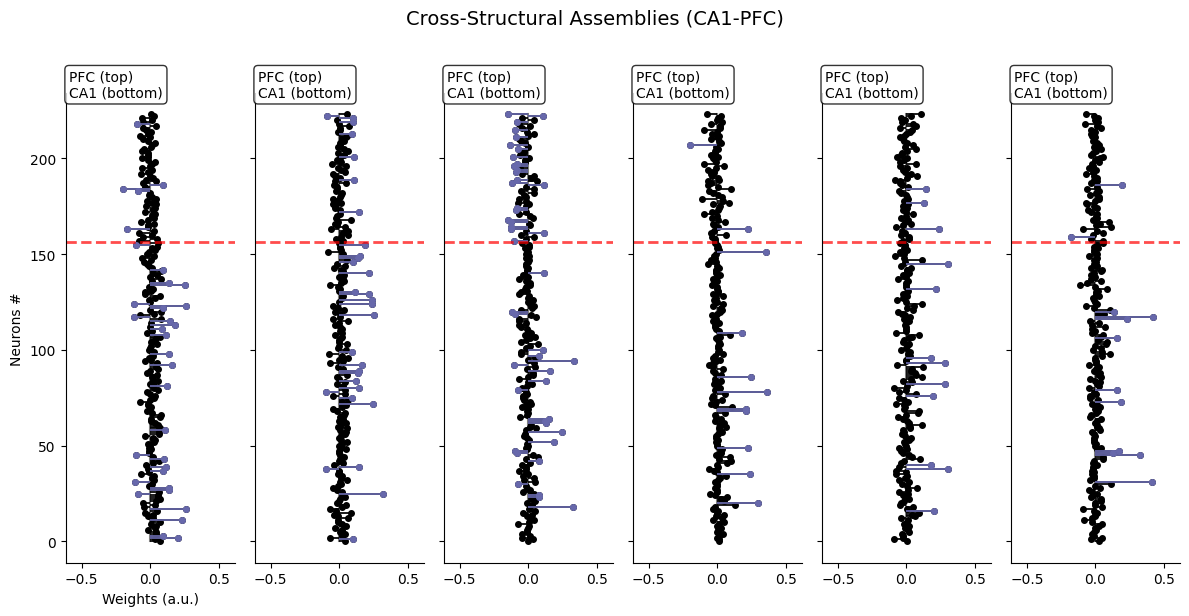


 Cross-structural assembly analysis:
  Assembly 1: CA1 neurons: 22, PFC neurons: 2
  Assembly 2: CA1 neurons: 19, PFC neurons: 4
  Assembly 3: CA1 neurons: 14, PFC neurons: 14
  Assembly 4: CA1 neurons: 12, PFC neurons: 4
  Assembly 5: CA1 neurons: 14, PFC neurons: 4
  Assembly 6: CA1 neurons: 14, PFC neurons: 3


In [13]:
if assembly_react_cross.n_assemblies() > 0:
    # Plot cross-structural assembly weights
    fig, axes = assembly_react_cross.plot(figsize=(12, 6))

    # Add vertical line to separate brain regions
    ca1_neurons = np.sum(brain_regions == "CA1")
    for ax in axes.flat:
        ax.axhline(
            ca1_neurons - 0.5, color="red", linestyle="--", alpha=0.7, linewidth=2
        )
        ax.text(
            0.02,
            1.05,
            f"PFC (top)\nCA1 (bottom)",
            transform=ax.transAxes,
            va="top",
            ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

    plt.suptitle("Cross-Structural Assemblies (CA1-PFC)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Analyze which regions participate in each assembly
    assembly_react_cross.find_members()

    print("\n Cross-structural assembly analysis:")
    for i in range(assembly_react_cross.n_assemblies()):
        pattern = assembly_react_cross.patterns[i]
        ca1_weights = np.abs(pattern[:ca1_neurons])
        ca3_weights = np.abs(pattern[ca1_neurons:])

        ca1_active = np.sum(ca1_weights > 0.1)
        ca3_active = np.sum(ca3_weights > 0.1)

        print(
            f"  Assembly {i + 1}: CA1 neurons: {ca1_active}, PFC neurons: {ca3_active}"
        )

else:
    print("No cross-structural assemblies detected in this dataset.")
    print("This could mean:")
    print("1. There are no assemblies spanning both regions")
    print("2. The assemblies are primarily within-region")
    print("3. More data or different parameters may be needed")

### Section 5.4: Compare Assembly Activity Between Standard and Cross-Structural Detection

Let's examine how cross-structural assemblies behave during ripples compared to standard assemblies.

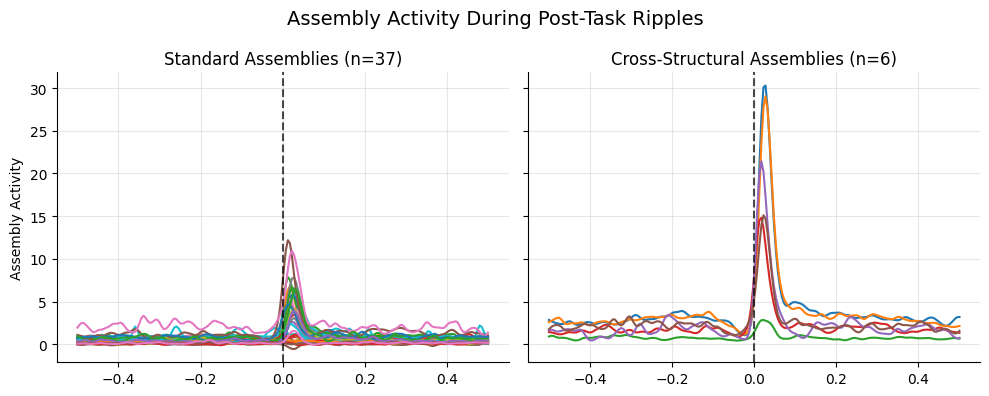

Peak activation comparison:
Standard assemblies (mean): 3.52
Cross-structural assemblies (mean): 18.92


In [14]:
assembly_act_standard = assembly_react_standard.get_assembly_act(
    epoch=assembly_react_standard.epochs[pre_task_post[0][2].item()]
)

# Compute assembly activity for cross-structural assemblies
assembly_act_cross = assembly_react_cross.get_assembly_act(
    epoch=assembly_react_cross.epochs[pre_task_post[0][2].item()]
)

nrem_ripples = ripples & nrem_epochs

psth_standard_post = npy.process.event_triggered_average(
    timestamps=assembly_act_standard.abscissa_vals,
    signal=assembly_act_standard.data.T,
    events=nrem_ripples[
        assembly_react_standard.epochs[pre_task_post[0][2].item()]
    ].starts,
    sampling_rate=assembly_act_standard.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)
psth_cross_post = npy.process.event_triggered_average(
    timestamps=assembly_act_cross.abscissa_vals,
    signal=assembly_act_cross.data.T,
    events=nrem_ripples[assembly_react_cross.epochs[pre_task_post[0][2].item()]].starts,
    sampling_rate=assembly_act_cross.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot standard assemblies
psth_standard_post.plot(ax=axes[0], legend=False)

axes[0].legend().set_visible(False)
# axes[0].set_title(f"Standard Assemblies (first {n_compare})")
axes[0].set_ylabel("Assembly Activity")
axes[0].axvline(0, linestyle="--", color="k", alpha=0.7)
axes[0].grid(True, alpha=0.3)
axes[0].set_title(f"Standard Assemblies (n={assembly_react_standard.n_assemblies()})")

# Plot cross-structural assemblies
psth_cross_post.plot(ax=axes[1], legend=False)
axes[1].set_title(
    f"Cross-Structural Assemblies (n={assembly_react_cross.n_assemblies()})"
)
axes[1].set_ylabel("Assembly Activity")
axes[1].axvline(0, linestyle="--", color="k", alpha=0.7)
axes[1].grid(True, alpha=0.3)

plt.suptitle("Assembly Activity During Post-Task Ripples", fontsize=14)
plt.tight_layout()
sns.despine()
plt.show()

# Compare peak activation
standard_peak = psth_standard_post.max().mean()
cross_peak = psth_cross_post.max().mean()

print(f"Peak activation comparison:")
print(f"Standard assemblies (mean): {standard_peak:.2f}")
print(f"Cross-structural assemblies (mean): {cross_peak:.2f}")


### Section 5.5: Visualizing Cross-Structural Correlation Matrix

A crucial step in cross-structural assembly analysis is filtering out within-structure (within-region) correlations. By masking these, we ensure that only interactions between neurons in different regions (e.g., CA1 and PFC) are considered when detecting cross-structural assemblies. This step is what enables the identification of assemblies that truly span multiple structures, rather than being dominated by strong within-region co-activity.

The plot below shows the neuron-neuron correlation matrix with within-region correlations masked out. The vertical red lines mark the region boundaries, and region labels are shown above the matrix for clarity. Only cross-region correlations remain visible, making patterns of inter-regional coordination stand out.

This visualization helps you:
- Confirm that the analysis is focused on cross-structural interactions
- Inspect the distribution and strength of cross-region correlations
- Identify coordinated activity that is not visible within a single region

Assemblies that are truly cross-structural will show strong off-diagonal blocks in this matrix, indicating coordinated activity between regions.

C:\Users\Cornell\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
C:\Users\Cornell\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide


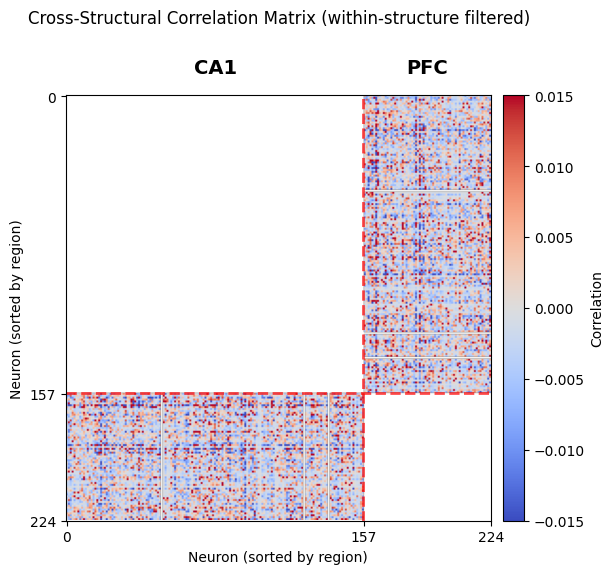

In [15]:
# Visualize cross-structural correlation matrix with within-structure filtered out
# Recompute the z-scored binned spike matrix using the method from AssemblyReact
zmat, _ = assembly_react_cross.get_z_mat(
    assembly_react_cross.st[
        assembly_react_cross.epochs[pre_task_post[0][1].item()] & theta_epochs
    ]
)

corr = np.corrcoef(zmat)

# Mask within-structure correlations
region_labels = brain_regions
mask = np.equal.outer(region_labels, region_labels)
corr_masked = corr.copy()
corr_masked[mask] = np.nan  # set within-structure to NaN

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_masked, cmap="coolwarm", vmin=-0.015, vmax=0.015)

# Add lines to separate regions
ca1_neurons = np.sum(brain_regions == "CA1")
ax.axhline(ca1_neurons - 0.5, color="red", linestyle="--", linewidth=2, alpha=0.7)
ax.axvline(ca1_neurons - 0.5, color="red", linestyle="--", linewidth=2, alpha=0.7)

# Axis labels and ticks
ax.set_xlabel("Neuron (sorted by region)")
ax.set_ylabel("Neuron (sorted by region)")
ax.set_xticks([0, ca1_neurons, len(brain_regions)])
ax.set_yticks([0, ca1_neurons, len(brain_regions)])
ax.set_xticklabels(["0", f"{ca1_neurons}", f"{len(brain_regions)}"])
ax.set_yticklabels(["0", f"{ca1_neurons}", f"{len(brain_regions)}"])

# Add region labels using text outside the plot area for visibility
ax.text(
    ca1_neurons / 2,
    -10,
    "CA1",
    ha="center",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
    clip_on=False,
)
ax.text(
    ca1_neurons + (len(brain_regions) - ca1_neurons) / 2,
    -10,
    "PFC",
    ha="center",
    va="bottom",
    fontsize=14,
    fontweight="bold",
    color="black",
    clip_on=False,
)

# Add the title above the region annotations by using fig.suptitle
fig.suptitle(
    "Cross-Structural Correlation Matrix (within-structure filtered)",
    fontsize=12,
    y=0.94,
)

# Colorbar
cbar = plt.colorbar(im, ax=ax, label="Correlation", pad=0.02)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### Section 5.6: Key Points About Cross-Structural Assembly Detection

**What it does:**
- Identifies assemblies that span across different groups (regions, cell types, etc.)
- Filters out assemblies that are confined to a single group
- Enables study of cross-regional coordination and communication

**When to use:**
- Studying hippocampal-cortical interactions
- Examining coordination between brain regions
- Investigating cell type-specific assembly dynamics
- Analyzing cross-electrode or cross-shank coordination

**Parameters:**
- `cross_structural`: A categorical array with the same length as the number of neurons
- Works with both `method='ica'` and `method='pca'`
- Compatible with all other `AssemblyReact` parameters

**Important considerations:**
- Requires sufficient neurons from multiple groups
- May detect fewer assemblies than standard detection (by design)
- Best used when you have a specific hypothesis about cross-structural coordination